DBSCAN группирует **плотно расположенные точки** (по сути, регионы с высокой плотностью точек) и отделяет **разреженные области** (выбросы, шум).

## Ключевые понятия
* Eps (ε) — радиус окрестности точки (ε-окрестность).
* MinPts — минимальное количество точек в ε-окрестности для того, чтобы считать точку "ядром".
* Core point (ядро) — точка, у которой в ε-окрестности не менее MinPts точек (включая саму себя).
* Border point (пограничная) — точка, которая сама не ядро, но находится в ε-окрестности некоторой core-точки.
* Noise point (шум) — точка, не являющаяся ни core, ни border.

## Как работает DBSCAN
1) Идём по каждой точке в наборе.
2) Если точка уже была рассмотрена — пропускаем.
3) Если точка — ядро:
    * запускаем расширение кластера:
    * все точки в её ε-окрестности:
    * если ядра — добавляем их в кластер и рекурсивно проверяем их соседей.
    * если пограничные — просто добавляем в кластер.
4) Если точка — не ядро и не попала ни в одну ε-окрестность — считаем шумом.

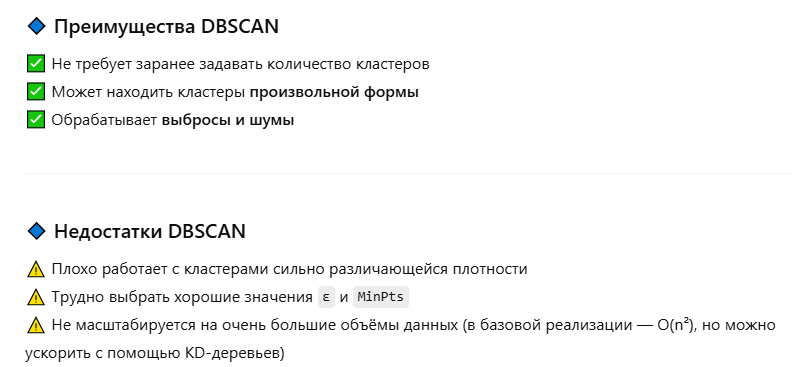

In [1]:
from IPython.display import Image
Image('char.png')

### Выбор параметров
* MinPts: обычно берётся ≥ размерности + 1 (например, для 2D — MinPts = 3 или 4)
* ε: можно подобрать по k-distance графику (строим расстояние до k-го соседа для всех точек и ищем "излом")

### Реализацию разобьём на этапы:
1) Расчёт расстояний
2) Нахождение соседей в ε-окрестности
3) Определение типа точки (core/border/noise)
4) Формирование кластеров

# Draft

In [4]:
import numpy as np
from collections import deque

def euclidean_distance(p1, p2): # Расчёт расстояний
    return np.sqrt(np.sum((p1 - p2) ** 2))

def region_query(data, point_idx, eps): # Нахождение соседей в ε-окрестности
    neighbors = []
    for idx, point in enumerate(data):
        if euclidean_distance(data[point_idx], point) <= eps:
            neighbors.append(idx)
    return neighbors


In [8]:
def expand_cluster(data, labels, point_idx, cluster_id, eps, min_pts):
    neighbors = region_query(data, point_idx, eps)

    if len(neighbors) < min_pts: # если соседей меньше, чем указанное число, то помечаем как шум, иначе делаем кластер
        labels[point_idx] = -1  # пометить как шум
        return False
    else:
        labels[point_idx] = cluster_id
        queue = deque(neighbors)

        while queue: # пока в очереди есть точки, нужно продолжать исследовать соседей текущего кластера
            # Очередь (queue) изначально содержит соседей core-точки, с которой началась кластеризация. Потом по ходу будут добавляться новые соседи других core-точек.
            current_idx = queue.popleft() # Забираем текущий индекс из начала очереди

            if labels[current_idx] == -1: # Проверяем, не был ли этот элемент ранее помечен как шум. Если был — мы теперь поняли, что он не шум, а все-таки часть кластера
                labels[current_idx] = cluster_id  # переопределяем шум как кластер

            elif labels[current_idx] is None: # Если точка еще не посещена (None), то она тоже может быть добавлена в кластер
                labels[current_idx] = cluster_id
                current_neighbors = region_query(data, current_idx, eps) # Ищем соседей этой новой точки — "региональная плотность", то есть все точки в пределах eps от нее.

                if len(current_neighbors) >= min_pts: # Если эта новая точка тоже оказывается core-точкой (у нее достаточно соседей), то
                    queue.extend(current_neighbors) # мы добавляем всех ее соседей в очередь, чтобы затем проверить их тоже и потенциально расширить кластер дальше.
        return True


In [12]:
def dbscan(data, eps, min_pts):
    labels =[None] * len(data) # None = не посещена
    cluster_id = 0

    for point_idx in range(len(data)):
        if labels[point_idx] is not None:
            continue

        if expand_cluster(data, labels, point_idx, cluster_id, eps, min_pts):
            cluster_id +=1

    return labels

In [13]:
# Пример: 2D данные
data = np.array([
    [1, 2],
    [2, 2],
    [2, 3],
    [8, 7],
    [8, 8],
    [25, 80],
])

labels = dbscan(data, eps=1.5, min_pts=2)
print("Labels:", labels)


Labels: [0, 0, 0, 1, 1, -1]


# Final

In [14]:
from collections import deque
import numpy as np

class MyDBSCAN:
    def __init__(self, eps=0.5, min_pts=5):
        self.eps = eps
        self.min_pts = min_pts
        self.labels_ = None

    def fit_predict(self, data):
        self.labels_ = [None] * len(data)
        cluster_id = 0

        for point_idx in range(len(data)):
            if self.labels_[point_idx] is not None:
                continue

            if self.expand_cluster(data, point_idx, cluster_id):
                cluster_id += 1

        return self.labels_

    def expand_cluster(self, data, point_idx, cluster_id):
        neighbors = self.region_query(data, point_idx)

        if len(neighbors) < self.min_pts:
            self.labels_[point_idx] = -1  # шум
            return False

        self.labels_[point_idx] = cluster_id
        queue = deque(neighbors)

        while queue:
            current_idx = queue.popleft()

            if self.labels_[current_idx] == -1:
                self.labels_[current_idx] = cluster_id  # шум -> кластер

            elif self.labels_[current_idx] is None:
                self.labels_[current_idx] = cluster_id
                current_neighbors = self.region_query(data, current_idx)

                if len(current_neighbors) >= self.min_pts:
                    queue.extend(current_neighbors)

        return True

    def region_query(self, data, point_idx):
        distances = np.linalg.norm(data - data[point_idx], axis=1)
        return list(np.where(distances <= self.eps)[0])

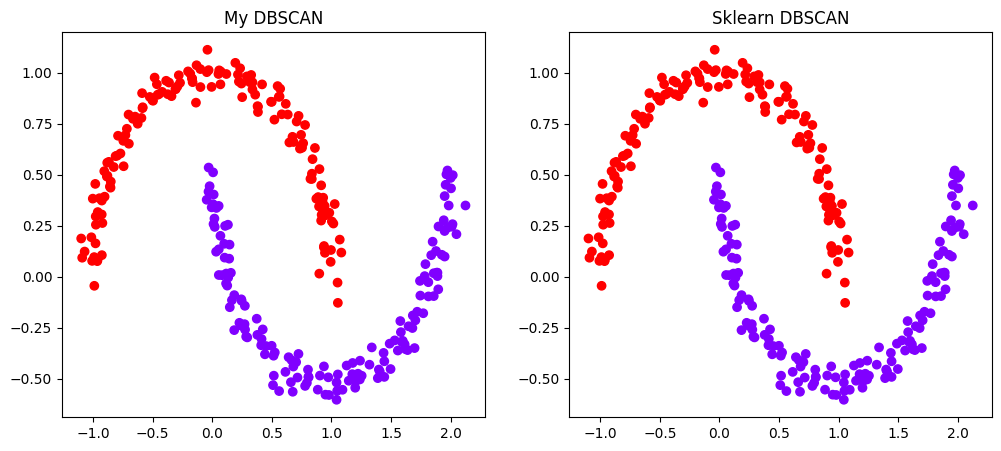

In [18]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN as SklearnDBSCAN

X, y_true  = make_moons(n_samples=300, noise=0.05, random_state=0)

# Моя реализация
my_dbscan = MyDBSCAN(eps=0.2, min_pts=5)
my_labels = my_dbscan.fit_predict(X)

# sklearn
sklearn_dbscan = SklearnDBSCAN(eps=0.2, min_samples=5)
sklearn_labels = sklearn_dbscan.fit_predict(X)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X[:, 0], X[:, 1], c=my_labels, cmap='rainbow')
axs[0].set_title("My DBSCAN")
axs[1].scatter(X[:, 0], X[:, 1], c=sklearn_labels, cmap='rainbow')
axs[1].set_title("Sklearn DBSCAN")
plt.show()


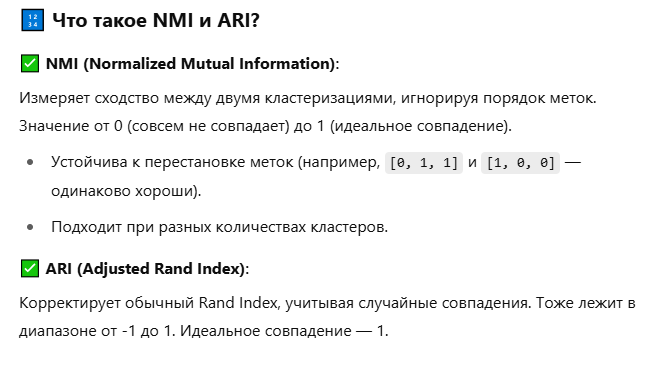

In [16]:
Image('nmi_ari.png')

In [19]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


In [23]:
# Метки из моей реализации
labels_our = my_dbscan.fit_predict(X)

# Метки из sklearn
from sklearn.cluster import DBSCAN
labels_sklearn = DBSCAN(eps=0.2, min_samples=5).fit_predict(X)

# Расчёт метрик
ari_my = adjusted_rand_score(y_true, labels_our)
nmi_my = normalized_mutual_info_score(y_true, labels_our)

ari_sklearn = adjusted_rand_score(y_true, labels_sklearn)
nmi_sklearn = normalized_mutual_info_score(y_true, labels_sklearn)

# Вывод
print("=== Моя реализация DBSCAN ===")
print(f"ARI: {ari_my:.4f}")
print(f"NMI: {nmi_my:.4f}")

print("\n=== Sklearn DBSCAN ===")
print(f"ARI: {ari_sklearn:.4f}")
print(f"NMI: {nmi_sklearn:.4f}")


=== Моя реализация DBSCAN ===
ARI: 1.0000
NMI: 1.0000

=== Sklearn DBSCAN ===
ARI: 1.0000
NMI: 1.0000


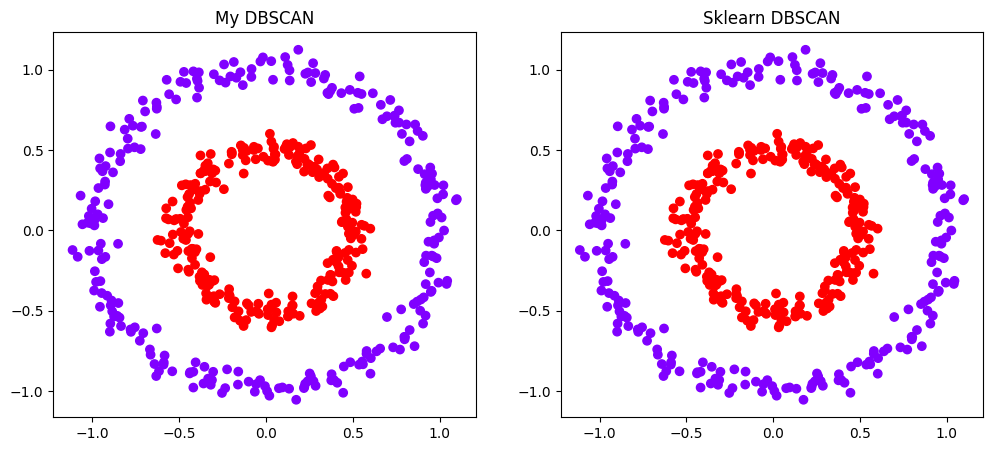

In [24]:
from sklearn.datasets import make_circles

X, y_true = make_circles(n_samples=500, noise=0.05, factor=0.5)
# Моя реализация
my_dbscan = MyDBSCAN(eps=0.2, min_pts=5)
my_labels = my_dbscan.fit_predict(X)

# sklearn
sklearn_dbscan = SklearnDBSCAN(eps=0.2, min_samples=5)
sklearn_labels = sklearn_dbscan.fit_predict(X)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X[:, 0], X[:, 1], c=my_labels, cmap='rainbow')
axs[0].set_title("My DBSCAN")
axs[1].scatter(X[:, 0], X[:, 1], c=sklearn_labels, cmap='rainbow')
axs[1].set_title("Sklearn DBSCAN")
plt.show()

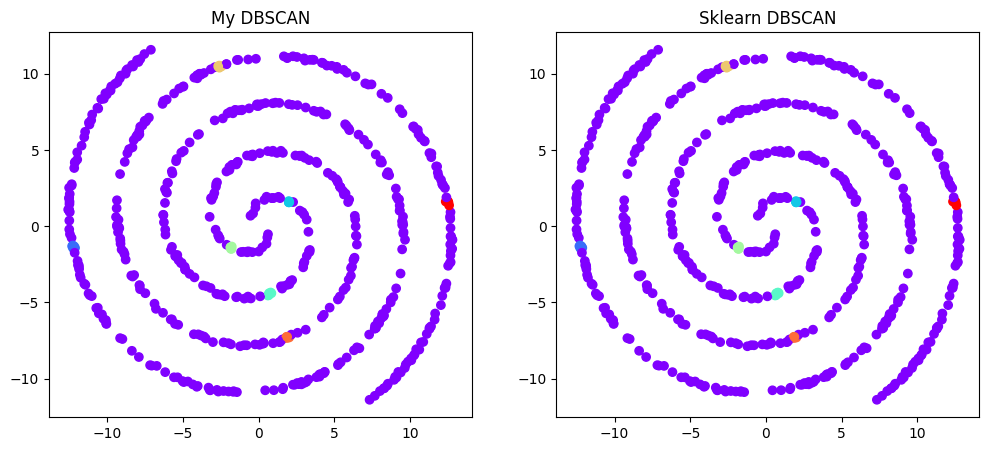

In [25]:
import numpy as np

def make_spiral(n_points, noise=0.05):
    n = np.sqrt(np.random.rand(n_points)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points) * noise

    d2x = np.cos(n)*n + np.random.rand(n_points) * noise
    d2y = -np.sin(n)*n + np.random.rand(n_points) * noise

    return np.vstack((np.append(d1x, d2x), np.append(d1y, d2y))).T

X = make_spiral(300, noise=0.2)
y_true = np.array([0]*300 + [1]*300)
my_dbscan = MyDBSCAN(eps=0.2, min_pts=5)
my_labels = my_dbscan.fit_predict(X)

# sklearn
sklearn_dbscan = SklearnDBSCAN(eps=0.2, min_samples=5)
sklearn_labels = sklearn_dbscan.fit_predict(X)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X[:, 0], X[:, 1], c=my_labels, cmap='rainbow')
axs[0].set_title("My DBSCAN")
axs[1].scatter(X[:, 0], X[:, 1], c=sklearn_labels, cmap='rainbow')
axs[1].set_title("Sklearn DBSCAN")
plt.show()

In [27]:
my_labels = my_dbscan.fit_predict(X)          # Мои метки
sklearn_labels = sklearn_dbscan.fit_predict(X) # Метки от sklearn

ari = adjusted_rand_score(my_labels, sklearn_labels)
nmi = normalized_mutual_info_score(my_labels, sklearn_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Adjusted Rand Index (ARI): 1.0000
Normalized Mutual Information (NMI): 1.0000
